Guide: https://www.youtube.com/watch?v=Jy4wM2X21u0&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=3

In [1]:
# importing necessary packages 

import torch # the library
import torch.nn as nn # neural network modules - CNNs, RNNs, Linear
import torch.optim as optim # optimizers like SGD, Adam etc
import torch.nn.functional as F # Activation Functions
from torch.utils.data import DataLoader, TensorDataset # helps load data, make batches
import torchvision.datasets as datasets #datasets on pytorch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms # helps transfrom datasets
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

Basically nn.Module is the parent class that contains all the neural network functions which we need. 
To build a neural network we make a child class "NN" which inherits from the parent class. 
To use the functions defined in the parent class, we use super, and then we initialize our neural network using
super(NN, self).__init__() 
where NN is the child class and super allows it to inherit functions from the nn.Module parent.

In [2]:
def load_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def load_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

In [3]:
# Define file paths
base_path = "/kaggle/input/mnist-dataset/"  # Adjust this path to your actual dataset
print(os.listdir(base_path))

train_images = load_images(os.path.join(base_path, "train-images.idx3-ubyte"))
train_labels = load_labels(os.path.join(base_path, "train-labels.idx1-ubyte"))

test_images = load_images(os.path.join(base_path, "t10k-images.idx3-ubyte"))
test_labels = load_labels(os.path.join(base_path, "t10k-labels.idx1-ubyte"))

# Confirm shapes
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")

['t10k-labels-idx1-ubyte', 'train-images.idx3-ubyte', 't10k-images-idx3-ubyte', 't10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 'train-labels.idx1-ubyte', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte']
Train images shape: (60000, 28, 28)
Train labels shape: (60000,)


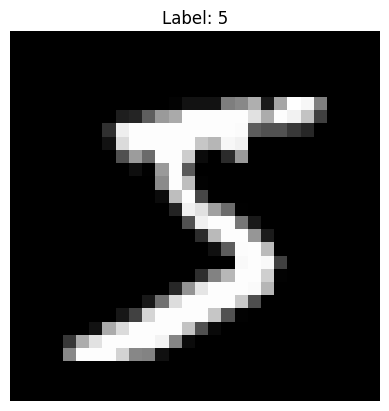

In [4]:
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.axis('off')
plt.show()

**CONVERSION FROM NUMPY TO TENSOR**

When you convert NumPy arrays (like raw pixel values from MNIST) to PyTorch tensors, normalization is critical for effective and stable training of your neural network.
The raw images you load from .idx files or images usually have values in the range: 0-255
But PyTorch models — especially neural networks — expect inputs in a much smaller range
dtype: float32
range: [0.0, 1.0] or [-1.0, 1.0]
tensor = torch.from_numpy(array).float() / 255.0
You:

Convert to float: neural networks work best with float32

Scale to [0, 1]: consistent input scale helps training

In [5]:
# https://docs.pytorch.org/docs/stable/generated/torch.from_numpy.html#torch.from_numpy
train_images_tensor = torch.from_numpy(train_images).float() / 255.0
train_images_tensor = train_images_tensor.unsqueeze(1) # unsqueezes the channel which is required by CNNS
train_labels_tensor = torch.from_numpy(train_labels).long()
test_images_tensor = torch.from_numpy(test_images).float() / 255.0
test_images_tensor = test_images_tensor.unsqueeze(1)
test_labels_tensor = torch.from_numpy(test_labels).long()

/tmp/ipykernel_227/2008822088.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  train_images_tensor = torch.from_numpy(train_images).float() / 255.0


In [6]:
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

In [7]:
'''
class Car:
    def __init__(self):
        print("Car engine started.")

class Tesla(Car):
    def __init__(self):
        super(Tesla, self).__init__()  # Call the Car class's constructor
        print("Tesla features initialized.")

my_car = Tesla()
'''

'\nclass Car:\n    def __init__(self):\n        print("Car engine started.")\n\nclass Tesla(Car):\n    def __init__(self):\n        super(Tesla, self).__init__()  # Call the Car class\'s constructor\n        print("Tesla features initialized.")\n\nmy_car = Tesla()\n'

In [8]:
# Create a fully connected neural network
# https://docs.pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

class NN(nn.Module): # a new class NN that inherits from nn.Module (which is PyTorch’s base class for all neural networks)
    def __init__(self, input_size, num_classes): # 
        super(NN, self).__init__() # initialization, super() gives you access to methods in a parent class 
        self.fc1 = nn.Linear(input_size, 50) # Layer 1 input-> 50 nodes
        self.fc2 = nn.Linear(50, num_classes) # Layer 2 50-> num of classes

    def forward(self, x):
        #would run on input x
        x = self.fc1(x) # apply 1st linear tranformation
        x = F.relu(x) # apply activation
        x = self.fc2(x) # apply 2nd tranformation
        return x

model = NN(28*28, 10) #image pixel, 10 number of digits
x = torch.randn(64, 28*28)
print(model(x).shape)

torch.Size([64, 10])


In [9]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Hyperparameters
input_size = 784 # 28*28
num_classes = 10
batch_size = 64
learning_rate = 0.001
num_epochs = 4

In [11]:
# Create data loaders.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# N: Number of images
# C: channels - grayscale = 1 channel
#if colored  = rgb, channels = 3

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [12]:
model = NN(input_size = input_size, num_classes = num_classes).to(device)

In [13]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [14]:
# train NW
for epoch in range(num_epochs):
    for batch_id, (data, targets) in enumerate(train_loader):
        # Get data to CUDA
        data = data.to(device = device)
        targets = targets.to(device = device)
        # print(data.shape)
        # converting n-d matrix to 1-d vect
        # print(data.shape[0]) => 64

        # GET TO CORRECT SHAPE
        data = data.reshape(data.shape[0], -1)
        # 64 remains, 1-28-28 flattened

        # Forward Pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward Pass
        optimizer.zero_grad() #set all gradients to zero
        loss.backward()

        #gradient descent
        optimizer.step() #update the weights

In [15]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)

            # Get to correct shape
            x = x.reshape(x.shape[0], -1)

            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples
    

In [16]:
# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 96.70
Accuracy on test set: 96.10


In [17]:
# # load_data
# # train_dataset = MNIST(root = 'dataset/',train = True, transform = transforms.ToTensor(), download = True)
# train_dataset = datasets.MNIST(root="./data", train=True, download=True,transform = transforms.ToTensor())
# # train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
# # load_data
# # test_dataset = MNIST(root = 'dataset/',train = False, transform = transforms.ToTensor(), download = True)
# test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
# # train_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)